In [2]:
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

In [3]:
model_name = "mobilenet_v2_100_224"
model_handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
image_size = (224,224)
batch_size = 16
data_dir = "suit_data"

In [4]:
def build_dataset(subset):
      return tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=.20,
        subset=subset,
        label_mode="categorical",
        seed=123,
        image_size=image_size,
        batch_size=1)

In [5]:
train_ds    = build_dataset("training")
val_ds      = build_dataset("validation")

train_size  = train_ds.cardinality().numpy()
val_size    =   val_ds.cardinality().numpy()
class_names = tuple(train_ds.class_names)

Found 1112 files belonging to 5 classes.
Using 890 files for training.
Found 1112 files belonging to 5 classes.
Using 222 files for validation.


2022-01-05 07:36:38.706715: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-05 07:36:38.706790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-01-05 07:36:38.706830: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-01-05 07:36:38.706872: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-01-05 07:36:38.706911: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

In [6]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)

preprocessing_train = tf.keras.Sequential([
    normalization_layer,
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomTranslation(0, 0.2),
    tf.keras.layers.RandomTranslation(0.2, 0),
    tf.keras.layers.RandomZoom(0.2, 0.2),
    tf.keras.layers.RandomContrast(0.1),
])

preprocessing_val = tf.keras.Sequential([
    normalization_layer])

In [7]:
train_ds = train_ds.unbatch().batch(batch_size)
train_ds = train_ds.repeat()
train_ds = train_ds.map(lambda images, labels:(preprocessing_train(images), labels))

val_ds = val_ds.unbatch().batch(batch_size)
val_ds = val_ds.map(lambda images, labels:(preprocessing_val(images), labels))

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=image_size + (3,)),
    hub.KerasLayer(model_handle, trainable=True),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

In [9]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 2,230,277
Non-trainable params: 34,112
_________________________________________________________________


In [10]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [11]:
steps_per_epoch = train_size // batch_size
validation_steps = val_size // batch_size
hist = model.fit(
    train_ds,
    epochs=10, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/10
55/55 [==============================] - 58s 959ms/step - loss: 1.2440 - accuracy: 0.5830 - val_loss: 1.0008 - val_accuracy: 0.7163
Epoch 2/10
55/55 [==============================] - 50s 910ms/step - loss: 0.8152 - accuracy: 0.8467 - val_loss: 0.7421 - val_accuracy: 0.8606
Epoch 3/10
55/55 [==============================] - 50s 904ms/step - loss: 0.6840 - accuracy: 0.9279 - val_loss: 0.6707 - val_accuracy: 0.9279
Epoch 4/10
55/55 [==============================] - 50s 908ms/step - loss: 0.6566 - accuracy: 0.9359 - val_loss: 0.6516 - val_accuracy: 0.9087
Epoch 5/10
55/55 [==============================] - 50s 910ms/step - loss: 0.6150 - accuracy: 0.9542 - val_loss: 0.6731 - val_accuracy: 0.9135
Epoch 6/10
55/55 [==============================] - 50s 904ms/step - loss: 0.5955 - accuracy: 0.9634 - val_loss: 0.6513 - val_accuracy: 0.9087
Epoch 7/10
55/55 [==============================] - 50s 908ms/step - loss: 0.6049 - accuracy: 0.9622 - val_loss: 0.6569 - val_accuracy: 0.9183

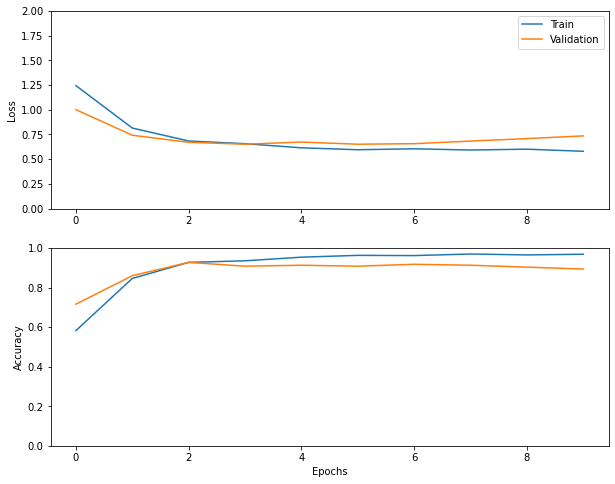

In [12]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,8))
ax1.set(ylabel="Loss", ylim=[0,2])
ax1.plot(hist["loss"], label="Train")
ax1.plot(hist["val_loss"], label="Validation")
ax1.legend()

ax2.set(ylabel="Accuracy", xlabel="Epochs", ylim=[0,1])
ax2.plot(hist["accuracy"])
ax2.plot(hist["val_accuracy"])

fig.savefig("train_loss.png")

In [13]:
model.save("/home/woojac/proj/031_shuffle/suit_predictor03")

2022-01-05 07:49:10.887569: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/woojac/proj/031_shuffle/suit_predictor03/assets


INFO:tensorflow:Assets written to: /home/woojac/proj/031_shuffle/suit_predictor03/assets
